# Assignment 4 - Neural Networks

## *Preet Khowaja*
Netid: pk201

*Names of students you worked with on this assignment*: LIST HERE IF APPLICABLE (delete if not)

Note: this assignment falls under collaboration Mode 2: Individual Assignment – Collaboration Permitted. Please refer to the syllabus for additional information.

Instructions for all assignments can be found [here](https://github.com/kylebradbury/ids705/blob/master/assignments/_Assignment%20Instructions.ipynb), and is also linked to from the [course syllabus](https://kylebradbury.github.io/ids705/index.html).

Total points in the assignment add up to 90; an additional 10 points are allocated to presentation quality.

# Learning objectives
Through completing this assignment you will be able to...
1. Identify key hyperparameters in neural networks and how they can impact model training and fit
2. Build, tune the parameters of, and apply feed-forward neural networks to data
3. Implement and explain each and every part of a standard fully-connected neural network and its operation including feed-forward propagation, backpropagation, and gradient descent.
4. Apply a standard neural network implementation and search the hyperparameter space to select optimized values.
5. Develop a detailed understanding of the math and practical implementation considerations of neural networks, one of the most widely used machine learning tools, so that it can be leveraged for learning about other neural networks of different model architectures.

# 1

## [65 points] Exploring and optimizing neural network hyperparameters
Neural networks have become ubiquitous in the machine learning community, demonstrating exceptional performance over a wide range of supervised learning tasks. The benefits of these techniques come at a price of increased computational complexity and model designs with increased numbers of hyperparameters that need to be correctly set to make these techniques work. It is common that poor hyperparameter choices in neural networks result in significant decreases in model generalization performance. The goal of this exercise is to better understand some of the key hyperparameters you will encounter in practice using neural networks so that you can be better prepared to tune your model for a given application. Through this exercise, you will explore two common approaches to hyperparameter tuning a manual approach where we greedily select the best individual hyperparameter (often people will pick potentially sensible options, try them, and hope it works) as well as a random search of the hyperparameter space which as been shown to be an efficient way to achieve good hyperparameter values. 

To explore this, we'll be using the example data created below throughout this exercise and the various training, validation, test splits. We will select each set of hyperparameters for our greedy/manual approach and the random search using a training/validation split, then retrain on the combined training and validation data before finally evaluating our generalization performance for both our final models on the test data.

In [1]:
# Optional for clear plotting on Macs
%config InlineBackend.figure_format='retina'

# Some of the network training leads to warnings. When we know and are OK with 
#  what's causing the warning and simply don't want to see it, we can use the 
#  following code. Run this block
#  to disable warnings
import sys
import os
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = 'ignore'

In [2]:
import numpy as np
from sklearn.model_selection import PredefinedSplit

#-----------------------------------------------------------------------------
# Create the data
#-----------------------------------------------------------------------------
# Data generation function to create a checkerboard-patterned dataset
def make_data_normal_checkerboard(n, noise=0):
    n_samples = int(n/4)
    shift = 0.5
    c1a = np.random.randn(n_samples,2)*noise + [-shift, shift]
    c1b = np.random.randn(n_samples,2)*noise + [shift, -shift]
    c0a = np.random.randn(n_samples,2)*noise + [shift, shift]
    c0b = np.random.randn(n_samples,2)*noise + [-shift, -shift]
    X = np.concatenate((c1a,c1b,c0a,c0b),axis=0)
    y = np.concatenate((np.ones(2*n_samples), np.zeros(2*n_samples)))
    
    # Set a cutoff to the data and fill in with random uniform data:
    cutoff = 1.25
    indices_to_replace = np.abs(X)>cutoff
    for index,value in enumerate(indices_to_replace.ravel()):
        if value:
            X.flat[index] = np.random.rand()*2.5-1.25
    return (X,y)

# Training datasets
np.random.seed(42)
noise = 0.45
X_train,y_train = make_data_normal_checkerboard(500, noise=noise)
    
# Validation and test data
X_val,y_val = make_data_normal_checkerboard(500, noise=noise)
X_test,y_test = make_data_normal_checkerboard(500, noise=noise)

# For RandomSearchCV, we will need to combine training and validation sets then
#  specify which portion is training and which is validation
# Also, for the final performance evaluation, train on all of the training AND validation data
X_train_plus_val = np.concatenate((X_train, X_val), axis=0)
y_train_plus_val = np.concatenate((y_train, y_val), axis=0)

# Create a predefined train/test split for RandomSearchCV (to be used later)
validation_fold = np.concatenate((-1*np.ones(len(y_train)), np.zeros(len(y_val))))
train_val_split = PredefinedSplit(validation_fold)

To help get you started we should always begin by visualizing our training data, here's some code that does that:

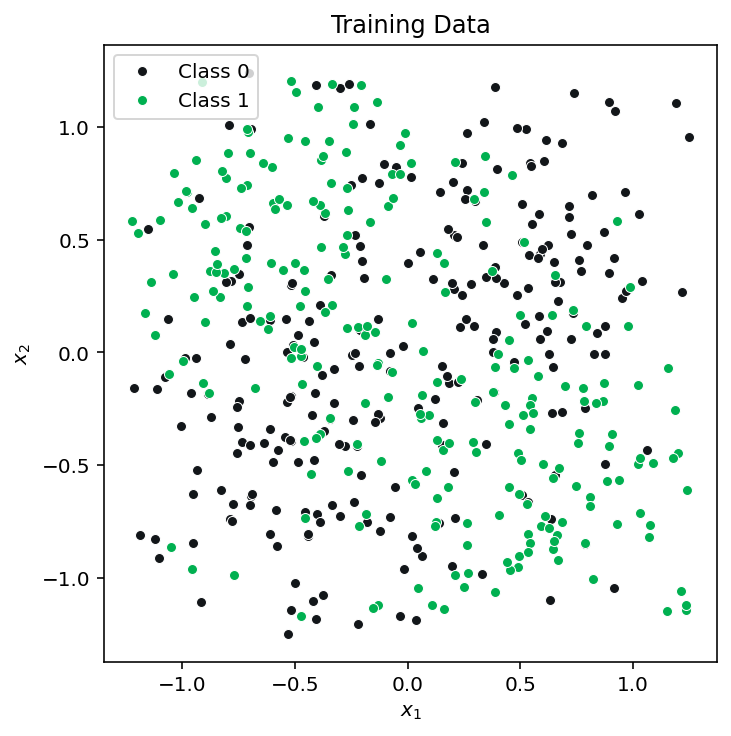

In [3]:
import matplotlib.pyplot as plt

# Code to plot the sample data
def plot_data(ax,X,y,title, limits):
    # Select the colors to use in the plots
    color0 = '#121619' # Dark grey
    color1 = '#00B050' # Green
    color_boundary='#858585'
    
    # Separate samples by class
    samples0 = X[y==0]
    samples1 = X[y==1]

    ax.plot(samples0[:,0],samples0[:,1],
        marker='o',
        markersize=5,
        linestyle="None",
        color=color0,
        markeredgecolor='w',
        markeredgewidth=0.5,
        label='Class 0')
    ax.plot(samples1[:,0],samples1[:,1],
        marker='o',
        markersize=5,
        linestyle="None",
        color=color1,
        markeredgecolor='w',
        markeredgewidth=0.5,
        label='Class 1')
    ax.set_title(title)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend(loc='upper left')
    ax.set_aspect('equal')

fig, ax = plt.subplots(constrained_layout=True, figsize=(5,5))
limits = [-1.25, 1.25, -1.25, 1.25]
plot_data(ax, X_train, y_train, 'Training Data', limits)

The hyperparameters we want to explore control the architecture of our model and how our model is fit to our data. These hyperparameters include the (a) learning rate, (b) batch size, and the (c) regularization coefficient, as well as the (d) model architecture hyperparameters (the number of layers and the number of nodes per layer). We'll explore each of these and determine an optimized configuration of the network for this problem through this exercise. For all of the settings we'll explore and just, we'll assume the following default hyperparameters for the model (we'll use scikit learn's [`MLPClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier.score) as our neural network model):
- `learning_rate_init` = 0.03
- `hidden_layer_sizes` = (30,30) (two hidden layers, each with 30 nodes)
- `alpha` = 0 (regularization penalty)
- `solver` = 'sgd' (stochastic gradient descent optimizer)
- `tol` = 1e-5 (this sets the convergence tolerance)
- `early_stopping` = False (this prevents early stopping)
- `activation` = 'relu' (rectified linear unit)
- `n_iter_no_change` = 1000 (this prevents early stopping)
- `batch_size` = 50 (size of the minibatch for stochastic gradient descent)
- `max_iter` = 500 (maximum number of epochs, which is how many times each data point will be used, not the number of gradient steps)

This default setting is our initial guess of what good values may be. Notice there are many model hyperparameters in this list: any of these could potentially be options to search over. We constrain the search to those hyperparameters that are known to have a significant impact on model performance.

**(a) Visualize the impact of different hyperparameter choices on classifier decision boundaries.** Visualize the impact of different hyperparameter settings. Starting with the default settings above make the following changes (only change one hyperparameter at a time). For each hyperparameter value, plot the decision boundary on the training data (you will need to train the model once for each parameter value):
1. Vary the architecture (`hidden_layer_sizes`) by changing the number of nodes per layer while keeping the number of layers constant at 2: (2,2), (5,5), (30,30). Here (X,X) means a 2-layer network with X nodes in each layer.
2. Vary the learning rate: 0.0001, 0.01, 1
3. Vary the regularization: 0, 1, 10
4. Vary the batch size: 5, 50, 500

As you're exploring these settings, visit this website, the [Neural Network Playground](https://playground.tensorflow.org/#activation=relu&batchSize=10&dataset=xor&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=20&networkShape=2,1&seed=0.89022&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false), which will give you the chance to interactively explore the impact of each of these parameters on a similar dataset to the one we use in this exercise. The tool also allows you to adjust the learning rate, batch size, regularization coefficient, and the architecture and to see the resulting decision boundary and learning curves. You can also visualize the model's hidden node output and its weights, and it allows you to add in transformed features as well. Experiment by adding or removing hidden layers and neurons per layer and vary the hyperparameters.

**ANSWER Part a)**

In [4]:
from sklearn.neural_network import MLPClassifier

base_model = MLPClassifier(learning_rate_init= 0.03,
                            hidden_layer_sizes=(30,30),
                            alpha = 0,
                            solver = 'sgd',
                            tol = 1e-5,
                            early_stopping= False,
                            activation= 'relu',
                            n_iter_no_change=1000,
                            batch_size= 50,
                            max_iter= 500)
base_model.fit(X_train, y_train)

MLPClassifier(alpha=0, batch_size=50, hidden_layer_sizes=(30, 30),
              learning_rate_init=0.03, max_iter=500, n_iter_no_change=1000,
              solver='sgd', tol=1e-05)

In [27]:
from matplotlib.colors import ListedColormap 

**1. Vary the architecture (`hidden_layer_sizes`) by changing the number of nodes per layer while keeping the number of layers constant at 2**

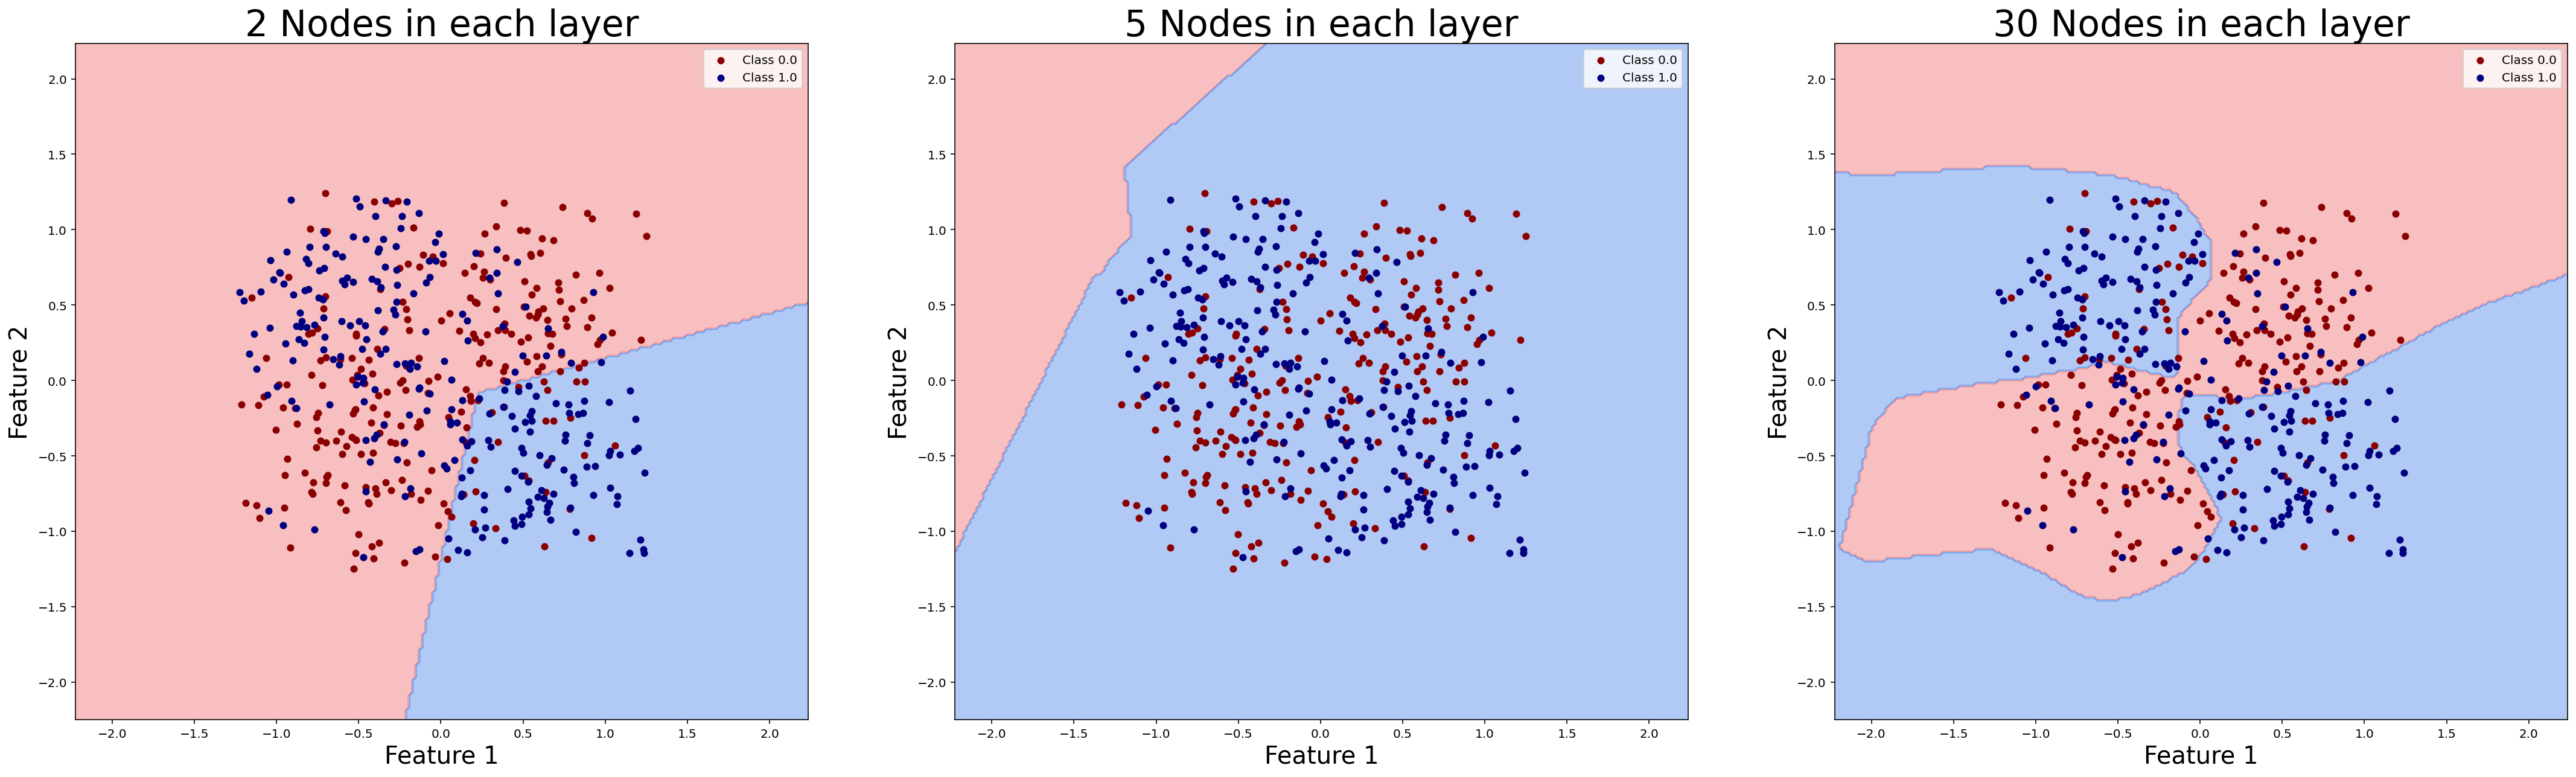

In [49]:
# Varying the hidden layer sizes, keeping 2 layers constant 

plt.rcParams['figure.figsize'] =(37, 35)

layer_sizes = [(2,2), (5,5), (30,30)]
titles = ['2 Nodes in each layer', '5 Nodes in each layer', '30 Nodes in each layer']
cmap_light = ListedColormap(["lightcoral", "cornflowerblue"])
cmap_bold = {0: 'darkred', 1: 'navy'}

for i, j, tag in zip(layer_sizes, [1, 2, 3], titles):

    model = MLPClassifier(learning_rate_init= 0.03,
                            hidden_layer_sizes=i,
                            alpha = 0,
                            solver = 'sgd',
                            tol = 1e-5,
                            early_stopping= False,
                            activation= 'relu',
                            n_iter_no_change=1000,
                            batch_size= 50,
                            max_iter= 500)
    model.fit(X_train, y_train)

    plt.subplot(3, 3, j)

    # Creating the grid
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap = cmap_light , alpha = 0.5)

    for label in np.unique(y_train):
        ind = np.where(y_train == label)
        plt.scatter(X_train[ind, 0], X_train[ind, 1], c = cmap_bold[label], s = 25, 
                                            label = 'Class {}'.format(label))
    
    plt.xlabel("Feature 1", fontsize = 20)
    plt.ylabel("Feature 2", fontsize = 20)
    plt.title(tag, fontsize = 30)
    plt.legend(fontsize = 10)
    

**2. Vary the learning rate: 0.0001, 0.01, 1**

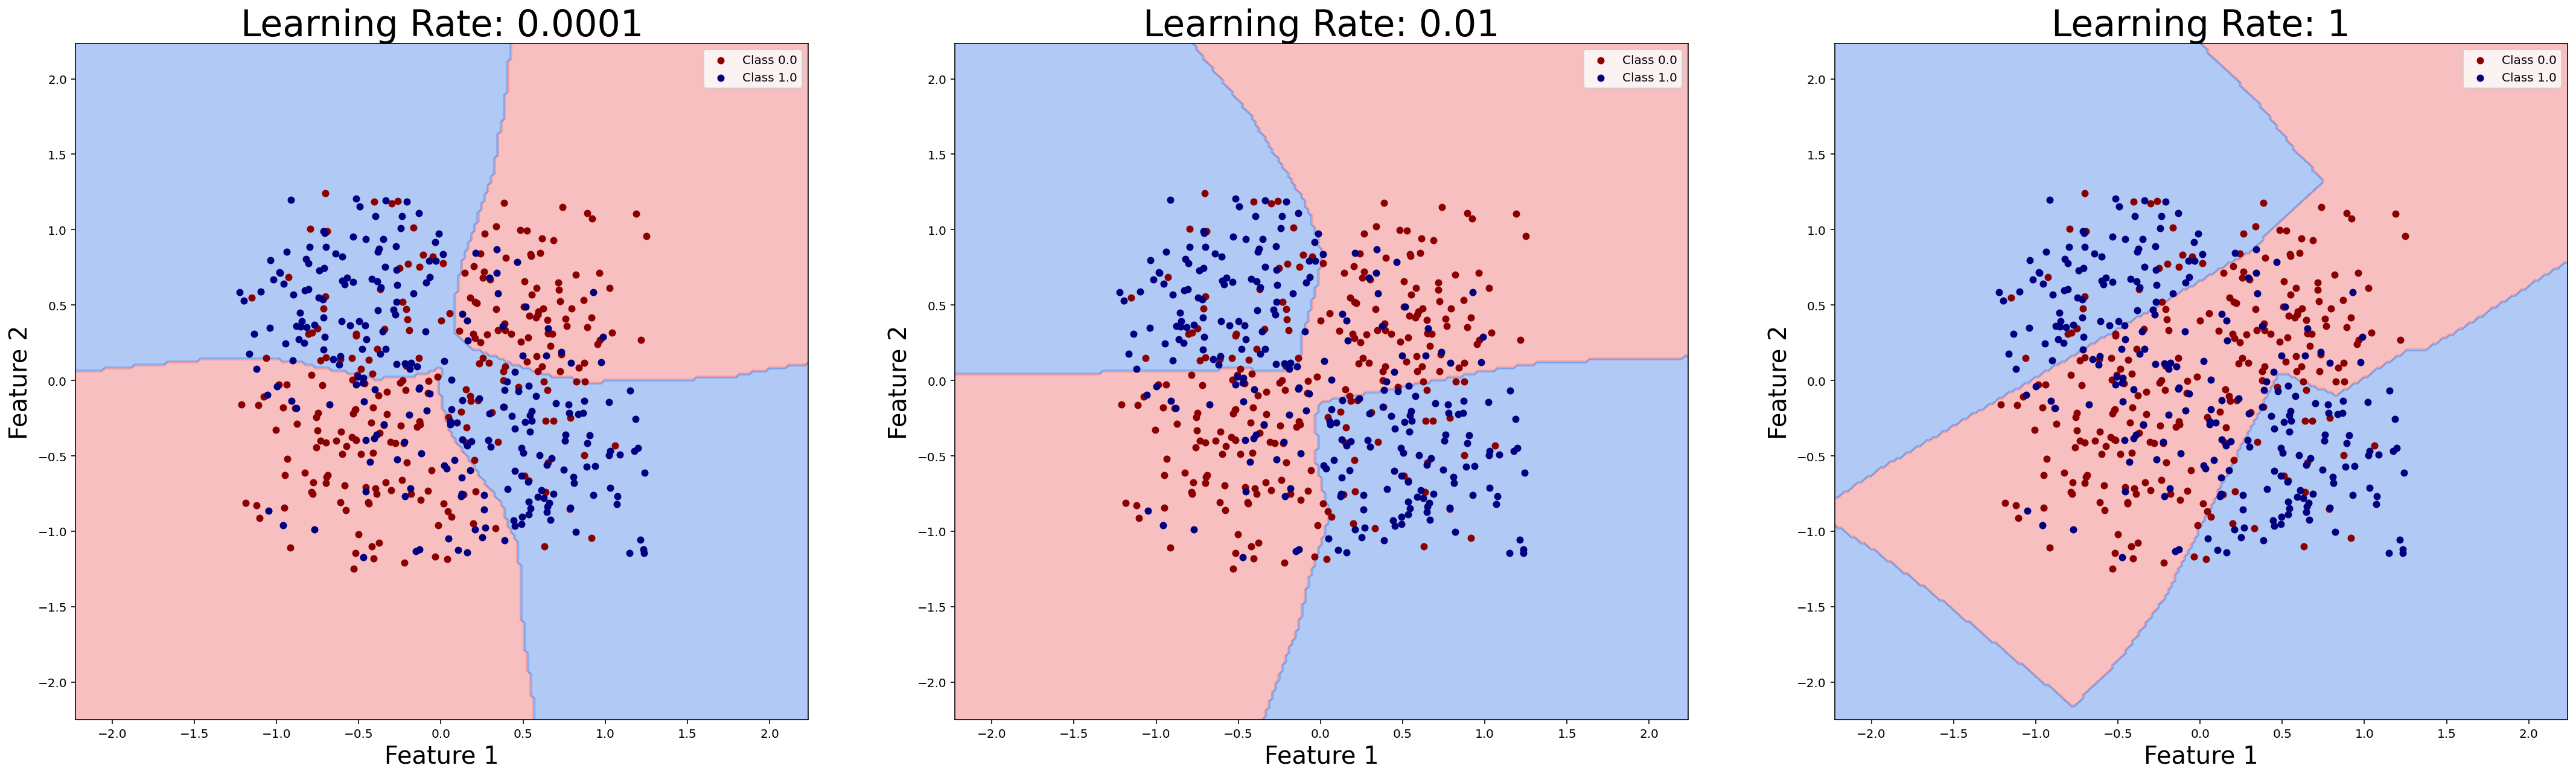

In [50]:
# Varying the learning rates 

plt.rcParams['figure.figsize'] =(37, 35)

lr = [0.0001, 0.01, 1]
titles = ['Learning Rate: 0.0001', 'Learning Rate: 0.01', 'Learning Rate: 1']
cmap_light = ListedColormap(["lightcoral", "cornflowerblue"])
cmap_bold = {0: 'darkred', 1: 'navy'}

for i, j, tag in zip(lr, [1, 2, 3], titles):

    model = MLPClassifier(learning_rate_init= i,
                            hidden_layer_sizes=(30,30),
                            alpha = 0,
                            solver = 'sgd',
                            tol = 1e-5,
                            early_stopping= False,
                            activation= 'relu',
                            n_iter_no_change=1000,
                            batch_size= 50,
                            max_iter= 500)
    model.fit(X_train, y_train)

    plt.subplot(3, 3, j)

    # Creating the grid
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap = cmap_light , alpha = 0.5)

    for label in np.unique(y_train):
        ind = np.where(y_train == label)
        plt.scatter(X_train[ind, 0], X_train[ind, 1], c = cmap_bold[label], s = 25, 
                                            label = 'Class {}'.format(label))
    
    plt.xlabel("Feature 1", fontsize = 20)
    plt.ylabel("Feature 2", fontsize = 20)
    plt.title(tag, fontsize = 30)
    plt.legend(fontsize = 10)
    

**3. Vary the regularization: 0, 1, 10**

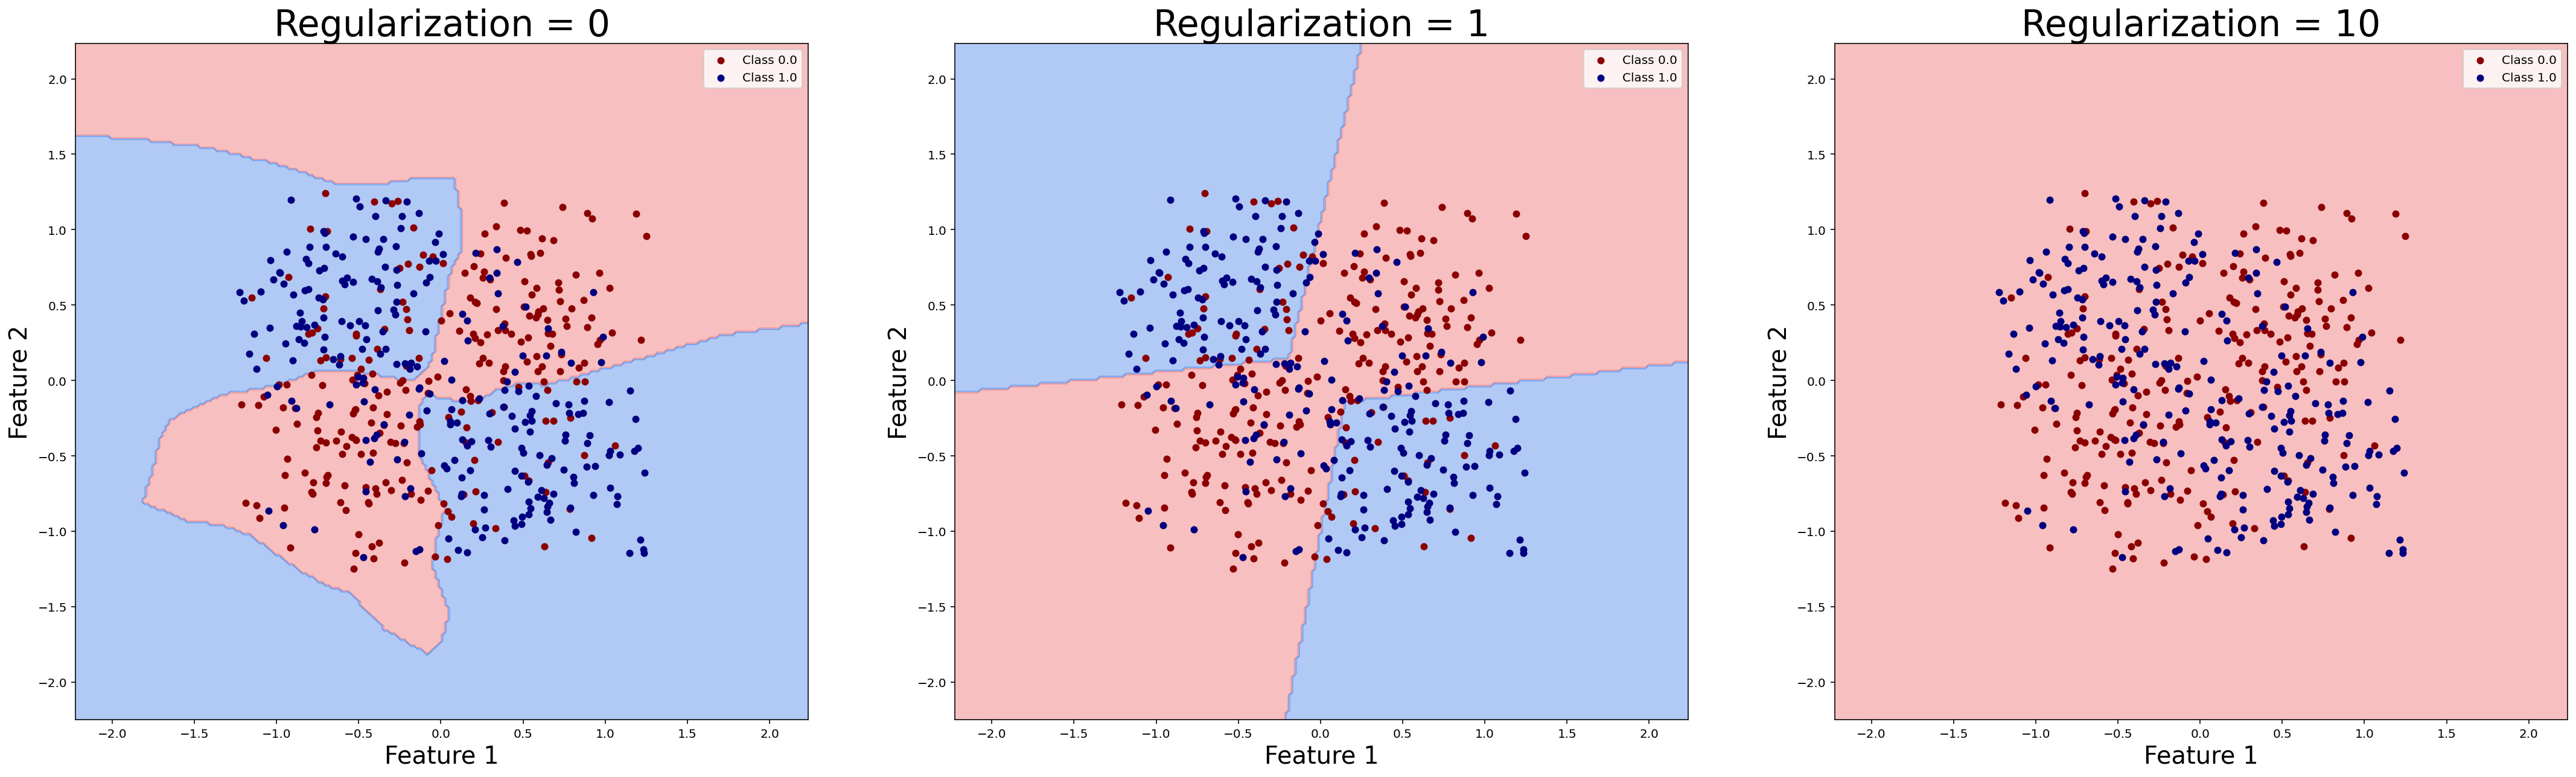

In [6]:
# Varying the learning rates 

plt.rcParams['figure.figsize'] =(37, 35)

reg = [0, 1, 10]
titles = ['Regularization = 0', 'Regularization = 1', 'Regularization = 10']
cmap_light = ListedColormap(["lightcoral", "cornflowerblue"])
cmap_bold = {0: 'darkred', 1: 'navy'}

for i, j, tag in zip(reg, [1, 2, 3], titles):

    model = MLPClassifier(learning_rate_init= 0.03,
                            hidden_layer_sizes=(30,30),
                            alpha = i,
                            solver = 'sgd',
                            tol = 1e-5,
                            early_stopping= False,
                            activation= 'relu',
                            n_iter_no_change=1000,
                            batch_size= 50,
                            max_iter= 500)
    model.fit(X_train, y_train)

    plt.subplot(3, 3, j)

    # Creating the grid
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap = cmap_light , alpha = 0.5)

    for label in np.unique(y_train):
        ind = np.where(y_train == label)
        plt.scatter(X_train[ind, 0], X_train[ind, 1], c = cmap_bold[label], s = 25, 
                                            label = 'Class {}'.format(label))
    
    plt.xlabel("Feature 1", fontsize = 20)
    plt.ylabel("Feature 2", fontsize = 20)
    plt.title(tag, fontsize = 30)
    plt.legend(fontsize = 10)
    

**4. Vary the batch size: 5, 50, 500**

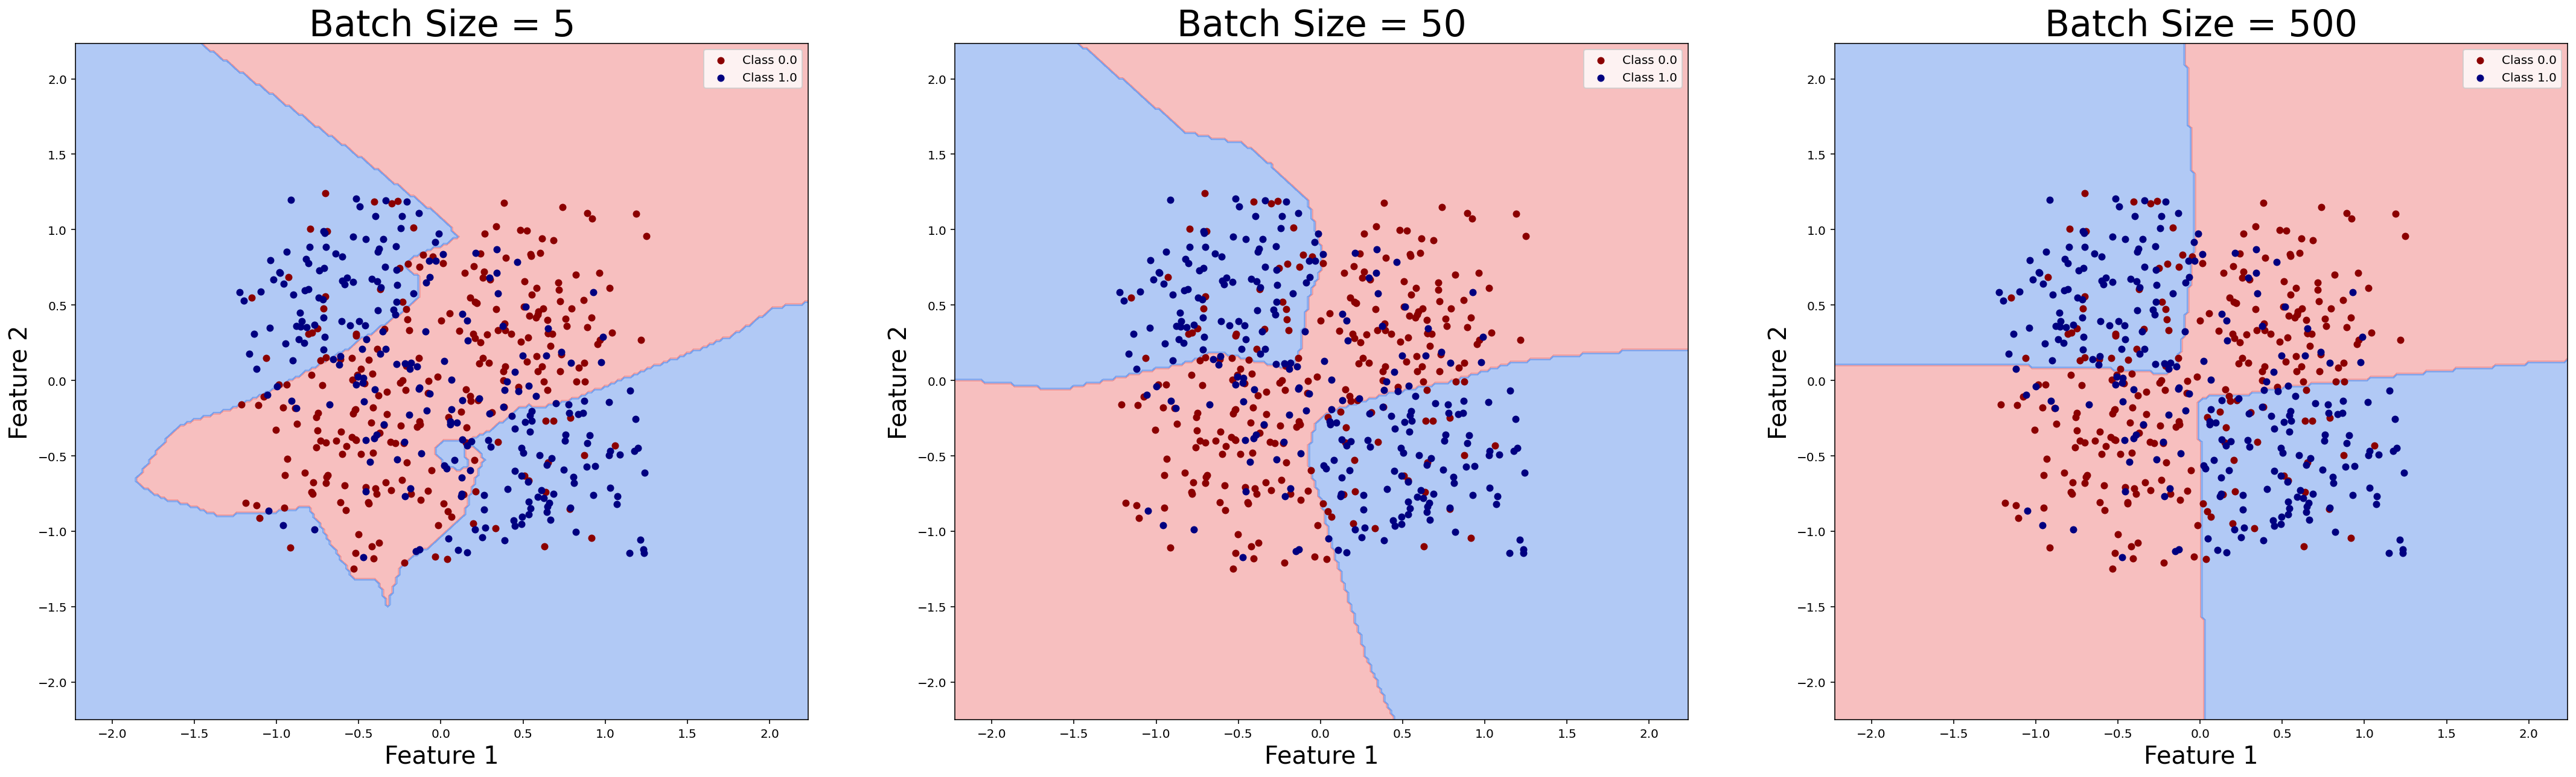

In [52]:
# Varying the learning rates 

plt.rcParams['figure.figsize'] =(37, 35)

batch_size = [5, 50, 500]
titles = ['Batch Size = 5', 'Batch Size = 50', 'Batch Size = 500']
cmap_light = ListedColormap(["lightcoral", "cornflowerblue"])
cmap_bold = {0: 'darkred', 1: 'navy'}

for i, j, tag in zip(batch_size, [1, 2, 3], titles):

    model = MLPClassifier(learning_rate_init= 0.03,
                            hidden_layer_sizes=(30,30),
                            alpha = 0,
                            solver = 'sgd',
                            tol = 1e-5,
                            early_stopping= False,
                            activation= 'relu',
                            n_iter_no_change=1000,
                            batch_size= i,
                            max_iter= 500)
    model.fit(X_train, y_train)

    plt.subplot(3, 3, j)

    # Creating the grid
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap = cmap_light , alpha = 0.5)

    for label in np.unique(y_train):
        ind = np.where(y_train == label)
        plt.scatter(X_train[ind, 0], X_train[ind, 1], c = cmap_bold[label], s = 25, 
                                            label = 'Class {}'.format(label))
    
    plt.xlabel("Feature 1", fontsize = 20)
    plt.ylabel("Feature 2", fontsize = 20)
    plt.title(tag, fontsize = 30)
    plt.legend(fontsize = 10)
    

**(b) Manual (greedy) hyperparameter tuning I: manually optimize hyperparameters that govern the learning process, one hyperparameter at a time.** Now with some insight into which settings may work better than others, let's more fully explore the performance of these different settings in the context of our validation dataset through a manual optimization process. Holding all else constant (with the default settings mentioned above), vary each of the following parameters as specified below. Train your algorithm on the training data, and evaluate the performance of your trained algorithm on the validation dataset. Here, overall accuracy is a reasonable performance metric since the classes are balanced and we don't weight one type of error as more important than the other; therefore, use the `score` method of the `MLPClassifier` for this. Create plots of accuracy vs each parameter you vary (this will result in three plots).
1. Vary learning rate logarithmically from $10^{-5}$ to $10^{0}$ with 20 steps
2. Vary the regularization parameter logarithmically from $10^{-8}$ to $10^2$ with 20 steps
3. Vary the batch size over the following values: $[1,3,5,10,20,50,100,250,500]$

For each of these cases:
- Based on the results, report your optimal choices for each of these hyperparameters and why you selected them.
- Since neural networks can be sensitive to initialization values, you may notice these plots may be a bit noisy. Consider this when selecting the optimal values of the hyperparameters. If the noise seems significant, run the fit and score procedure multiple times and report the average. Rerunning the algorithm will change the initialization and therefore the output (assuming you do not set a random seed for that algorithm).
- Use the chosen hyperparameter values as the new default settings for section (c) and (d).

**ANSWER Part b)**

**1. Vary learning rate logarithmically from $10^{-5}$ to $10^{0}$ with 20 steps**

In [7]:
# Create varying learning rates
learning_rates = np.logspace(-5, 0, 20)

# A list to store the accuracies for each learning rate above
accuracy_scores = []

for lr in learning_rates:
    mod = MLPClassifier(learning_rate_init= lr,
                            hidden_layer_sizes=(30,30),
                            alpha = 0,
                            solver = 'sgd',
                            tol = 1e-5,
                            early_stopping= False,
                            activation= 'relu',
                            n_iter_no_change=1000,
                            batch_size= 50,
                            max_iter= 500)

    mod.fit(X_train, y_train)
    accuracy_scores.append(mod.score(X_val, y_val))
    

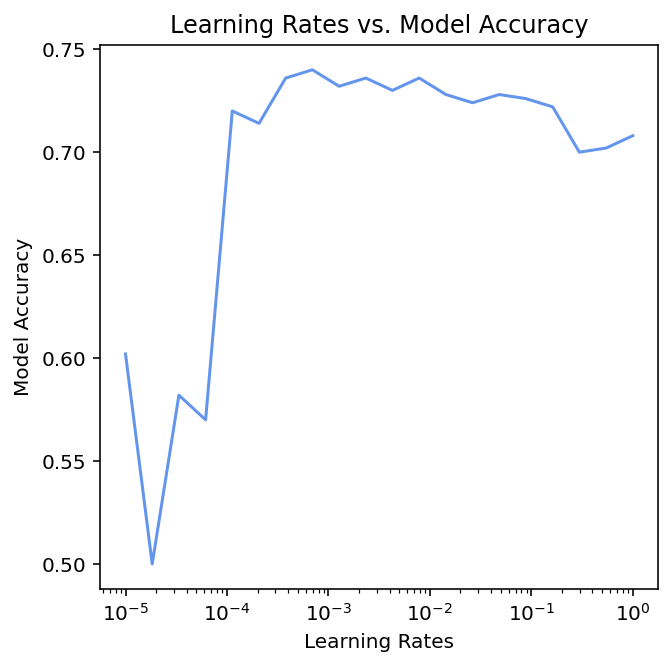

In [8]:
# Plotting change in accuracy as LR changes
plt.figure(figsize=(5,5))
plt.plot(learning_rates, accuracy_scores, color = 'cornflowerblue')
plt.xlabel('Learning Rates')
plt.xscale('log')
plt.ylabel('Model Accuracy')
plt.title("Learning Rates vs. Model Accuracy")
plt.show()

**2. Vary the regularization parameter logarithmically from $10^{-8}$ to $10^2$ with 20 steps**

In [9]:
# Create varying reg params
reg_params = np.logspace(-8, 2, 20)

# A list to store the accuracies for each learning rate above
accuracy_scores2 = []

for r in reg_params:
    mod = MLPClassifier(learning_rate_init= 0.03,
                            hidden_layer_sizes=(30,30),
                            alpha = r,
                            solver = 'sgd',
                            tol = 1e-5,
                            early_stopping= False,
                            activation= 'relu',
                            n_iter_no_change=1000,
                            batch_size= 50,
                            max_iter= 500)

    mod.fit(X_train, y_train)
    accuracy_scores2.append(mod.score(X_val, y_val))
    

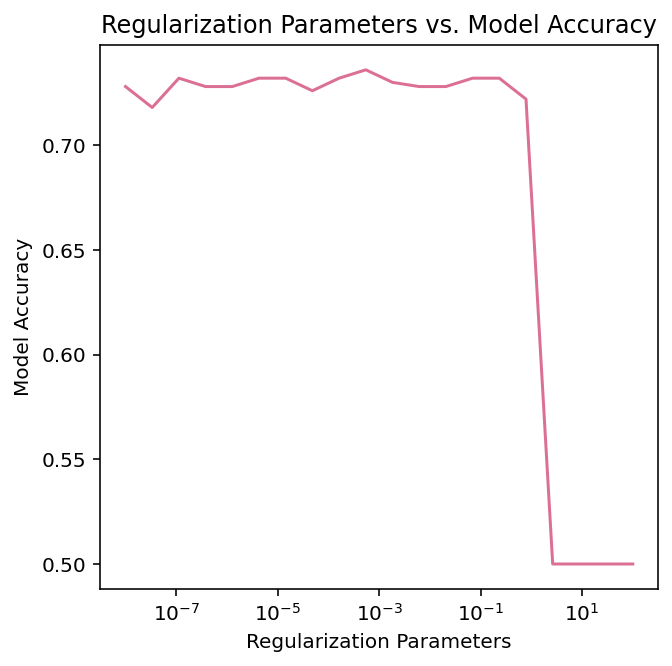

In [10]:
# Plotting change in accuracy as Regularization changes
plt.figure(figsize=(5,5))
plt.plot(reg_params, accuracy_scores2, color = 'palevioletred')
plt.xlabel('Regularization Parameters')
plt.xscale('log')
plt.ylabel('Model Accuracy')
plt.title("Regularization Parameters vs. Model Accuracy")
plt.show()

**3. Vary the batch size over the following values: $[1,3,5,10,20,50,100,250,500]$**

In [33]:
# Create varying batch sizes
batch_sizes = [1, 3, 5, 10, 20, 50, 100, 250, 500]

# A list to store the accuracies for each learning rate above
accuracy_scores3 = []

for b in batch_sizes:
    mod = MLPClassifier(learning_rate_init= 0.03,
                            hidden_layer_sizes=(30,30),
                            alpha = 0,
                            solver = 'sgd',
                            tol = 1e-5,
                            early_stopping= False,
                            activation= 'relu',
                            n_iter_no_change=1000,
                            batch_size= b,
                            max_iter= 500)

    mod.fit(X_train, y_train)
    accuracy_scores3.append(mod.score(X_val, y_val))
    

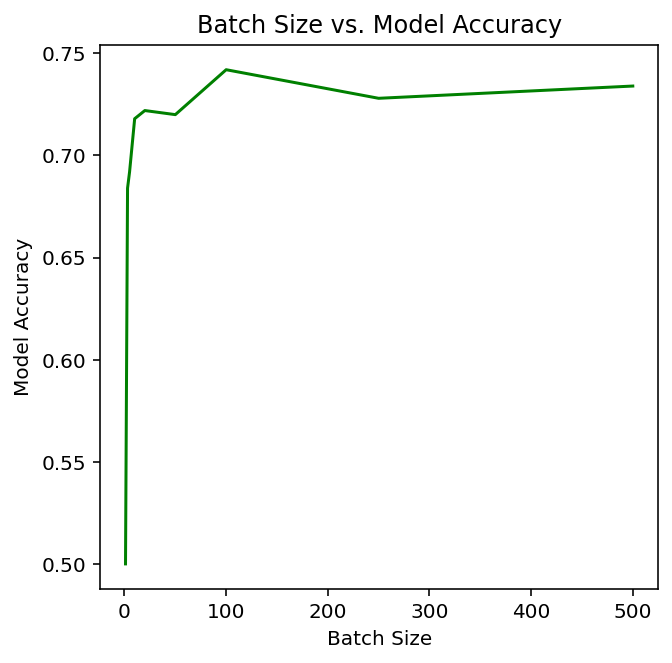

In [34]:
# Plotting change in accuracy as batch sizes change
plt.figure(figsize=(5,5))
plt.plot(batch_sizes, accuracy_scores3, color = 'green')
plt.xlabel('Batch Size')
plt.ylabel('Model Accuracy')
plt.title("Batch Size vs. Model Accuracy")
plt.show()

**For each of these cases based on the results, report your optimal choices for each of these hyperparameters and why you selected them.**

For each of the cases above, I will find for which value of the hyperparameter, my model's accuracy is highest and use that optimal value for the following parts. This is because my model's goal is to predict with high accuracy and that metric will inform my decision of the hyperparameters.

In [27]:
max_score = np.where(accuracy_scores == max(accuracy_scores))
learning_rates[max_score[0]][0]

0.0006951927961775605

The best learning rate value is 0.000695.

In [53]:
max_score2 = np.where(accuracy_scores2 == max(accuracy_scores2))
reg_params[max_score2[0]][0]

0.0005455594781168515

The optimal value for the regularization parameter is 0.000546.

In [52]:
max_score3 = np.where(accuracy_scores3 == max(accuracy_scores3))
batch_sizes[max_score3[0][0]]

100

The optimal value for batch size is 100.

**(c) Manual (greedy) hyperparameter tuning II: manually optimize hyperparameters that impact the model architecture.** Next, we want to explore the impact of the model architecture on performance and optimize its selection. This means varying two parameters at a time instead of one as above. To do this, evaluate the validation accuracy resulting from training the model using each pair of possible numbers of nodes per layer and number of layers from the lists below. We will assume that for any given configuration the number of nodes in each layer is the same (e.g. (2,2,2), which would be a 3-layer network with 2 hidden node in each layer and (25,25) are valid, but (2,5,3) is not because the number of hidden nodes varies in each layer). Use the manually optimized values for learning rate, regularization, and batch size selected from section (b). 
- Number of nodes per layer: $[1,2,3,4,5,10,15,25,30]$
- Number of layers = $[1,2,3,4]$
Report the accuracy of your model on the validation data. For plotting these results, use heatmaps to plot the data in two dimensions. To make the heatmaps, you can use [this code for creating heatmaps] https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html). Be sure to include the numerical values of accuracy in each grid square as shown in the linked example and label your x, y, and color axes as always. For these numerical values, round them to **2 decimal places** (due to some randomness in the training process, any further precision is not typically meaningful).

- When you select your optimized parameters, be sure to keep in mind that these values may be sensitive to the data and may offer the potential to have high variance for larger models. Therefore, select the model with the highest accuracy but lowest number of total model weights (all else equal, the simpler model is preferred). 
- What do the results show? Which parameters did you select and why?

**ANSWER Part c)**

In [5]:
# Creating architectural basics 
nodes = [1,2,3,4,5,10,15,25,30]
layers = [1,2,3,4]

heatmap_matrix = np.zeros((len(layers), len(nodes)))

In [8]:
# Creating model scores for each node, layer combination
for i in range(len(layers)):
    for j in range(len(nodes)):
        # Varying the layer size
        hid_layer = (nodes[j],) * layers[i]

        accuracy = []
        for x in [47, 56, 89]:
            iter_score = []
            model = MLPClassifier(learning_rate_init= 0.000695,
                            hidden_layer_sizes=hid_layer,
                            alpha = 0.000546,
                            solver = 'sgd',
                            tol = 1e-5,
                            early_stopping= False,
                            activation= 'relu',
                            n_iter_no_change=1000,
                            batch_size= 100,
                            max_iter= 500,
                            random_state= x)
            model.fit(X_train, y_train)
            iter_score.append(model.score(X_val, y_val))
        final_mean_score = np.mean(iter_score)
        heatmap_matrix[i,j] = final_mean_score

In [9]:
# Check our model scores
heatmap_matrix

array([[0.512, 0.576, 0.594, 0.544, 0.432, 0.664, 0.686, 0.702, 0.732],
       [0.5  , 0.59 , 0.59 , 0.682, 0.604, 0.714, 0.714, 0.714, 0.708],
       [0.5  , 0.574, 0.5  , 0.528, 0.688, 0.708, 0.732, 0.716, 0.714],
       [0.5  , 0.59 , 0.5  , 0.5  , 0.614, 0.718, 0.698, 0.694, 0.718]])

<Figure size 2880x2880 with 0 Axes>

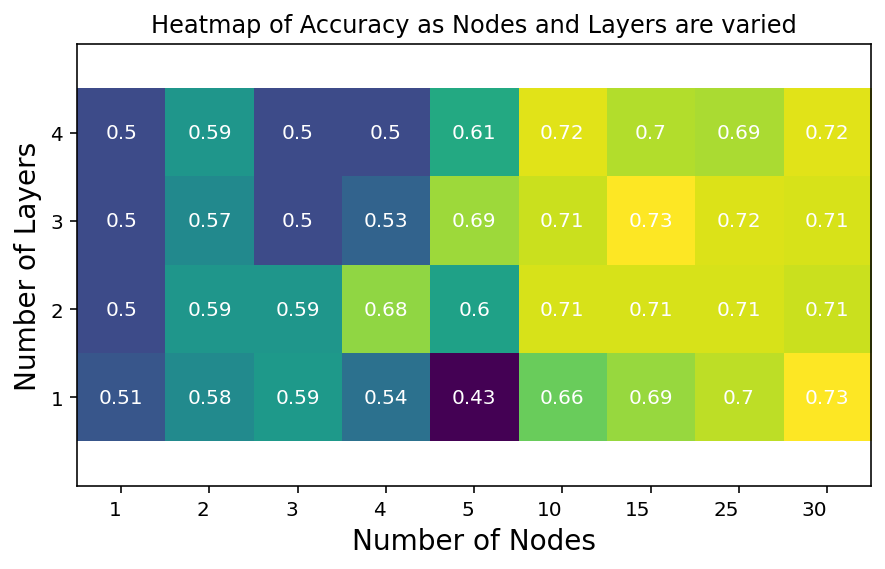

In [28]:
import matplotlib

# Create heatmap
plt.figure(figsize = (40,40))

fig, ax = plt.subplots()
image = ax.imshow(heatmap_matrix)

# Labelling axes
ax.set_xticks(np.arange(len(nodes)))
ax.set_yticks(np.arange(len(layers)))

ax.set_xticklabels(nodes)
ax.set_yticklabels(layers)
ax.set_ylim(-1, 4)

plt.setp(ax.get_xticklabels(), ha = 'right', rotation_mode = 'anchor')

for i in range(len(layers)):
    for j in range(len(nodes)):
        number = round(heatmap_matrix[i, j], 2) 
        acc_text = ax.text(j, i, number, ha = 'center', va = 'center', color = 'w', size = 10)

ax.set_title("Heatmap of Accuracy as Nodes and Layers are varied")
fig.tight_layout()
plt.xlabel('Number of Nodes', fontsize = 14)
plt.ylabel('Number of Layers', fontsize = 14)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()

In [35]:
# Finding average accuracy for each row in the heatmap above
for i in range(4):
    print('For ' + str(i+1) + ' layers, the average accuracy is: ' + str(heatmap_matrix[i].mean()))

For 1 layers, the average accuracy is: 0.6046666666666667
For 2 layers, the average accuracy is: 0.6462222222222223
For 3 layers, the average accuracy is: 0.6288888888888889
For 4 layers, the average accuracy is: 0.6146666666666667


**What do the results show? Which parameters did you select and why?**

The heatmap shows that increasing the number of nodes has a significant impact on improving prediction accuracy. A similar impact is not seen as I varied the number of layers. I averaged out the accuracies for each layer and picked the layer with the highest average accuracy. In this case, it was **2 layers**. 

Even though using 30 nodes in each layer shows high accuracy, this may be overfitting the data. Hence, I picked **10 nodes in each layer**, since this does reveal approximately 70% accuracy and is unlikely to overfit the data. 

**(d) Manual (greedy) model selection and retraining.** Based the optimal choice of hyperparameters, train your model with your optimized hyperparameters on all the training data AND the validation data (this is provided as `X_train_plus_val` and `y_train_plus_val`). 
- Apply the trained model to the test data and report the accuracy of your final model on the test data.
- Plot an ROC curve of your performance (plot this with the curve in part (e) on the same set of axes you use for that question).

**ANSWER Part d)**

In [22]:
# Training model on train and validation data
# using optimal parameter values

optimized_manual_model = MLPClassifier(learning_rate_init= 0.000695,
                            hidden_layer_sizes=(10,10),
                            alpha = 0.000546,
                            solver = 'sgd',
                            tol = 1e-5,
                            early_stopping= False,
                            activation= 'relu',
                            n_iter_no_change=1000,
                            batch_size= 100,
                            max_iter= 500,
                            random_state= 101010)
optimized_manual_model.fit(X_train_plus_val, y_train_plus_val)

MLPClassifier(alpha=0.000546, batch_size=100, hidden_layer_sizes=(10, 10),
              learning_rate_init=0.000695, max_iter=500, n_iter_no_change=1000,
              random_state=101010, solver='sgd', tol=1e-05)

In [23]:
print("The accuracy of the model with optimized parameters on the test data is:"
" {}".format(optimized_manual_model.score(X_test, y_test)))

The accuracy of the model with optimized parameters on the test data is: 0.722


*See Part e) for ROC curve*

**(e)** **Automated hyperparameter search through random search**. The manual (greedy) approach (setting one or two parameters at a time holding the rest constant), provides good insights into how the neural network hyperparameters impacts model fitting for this particular training process. However, it is limited in one very problematic way: it depends heavily on a good "default" setting of the hyperparameters. Those were provided for you in this exercise, but are not generally know. Our manual optimization was somewhat greedy because we picked the hyperparameters one at a time rather than looking at different combinations of hyperparameters. Adopting such a pseudo-greedy approach to that manual optimization also limits our ability to more deeply search the hyperparameter space since we don't look at simultaneous changes to multiple parameters. Now we'll use a popular hyperparameter optimization tool to accomplish that: random search.

Random search is an excellent example of a hyperparameter optimization search strategy that has [been shown to be more efficient](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a?ref=https://githubhelp.com) (requiring fewer training runs) than another common approach: grid search. Grid search evaluates all possible combinations of hyperparameters from lists of possible hyperparameter settings - a very computationally expensive process. Yet another attractive alternative is [Bayesian Optimization](https://arxiv.org/abs/1807.02811), which is an excellent hyperparameter optimization strategy but we will leave that to the interested reader.

Our particular random search tool will be Scikit-Learn's [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html#sklearn.model_selection.RandomizedSearchCV). This performs random search employing cross validation for performance evaluation (we will adjust this to ve a train/validation split). 

Using `RandomizedSearchCV`, train on the training data while validating on the validation data (see instructions below on how to setup the train/validation split automatically). This tool will randomly pick combinations of parameter values and test them out, returning the best combination it finds as measured by performance on the validation set. You can use [this example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) as a template for how to do this.
- To make this comparable to the training/validation setup used for the greedy optimization, we need to setup a training and validation split rather than use cross validation. To do this for `RandomSearchCV` we input the COMBINED training and validation dataset (`X_train_plus_val`, and `y_train_plus_val`) and we set the `cv` parameter to be the `train_val_split` variable we provided along with the dataset. This will setup the algorithm to make its assessments training just on the training data and evaluation on the validation data. Once `RandomSearchCV` completes its search, it will fit the model one more time to the combined training and validation data using the optimized parameters as we would want it to.
- Set the number of iterations to at least 200 (you'll look at 200 random pairings of possible hyperparameters). You can go as high as you want, but it will take longer the larger the value.
- If you run this on Colab or any system with multiple cores, set the parameter `n_jobs` to -1 to use all available cores for more efficient training through parallelization
- You'll need to set the range or distribution of the parameters you want to sample from. Search over the same ranges as in previous problems. To tell the algorithm the ranges to search, use lists of values for candidate batch_size, since those need to be integers rather than a range; the `loguniform` `scipy` function for setting the range of the learning rate and regularization parameter, and a list of tuples for the `hidden_layer_sizes` parameter, as you used in the greedy optimization.
- Once the model is fit, use the `best_params_` property of the fit classifier attribute to extract the optimized values of the hyperparameters and report those and compare them to what was selected through the manual, greedy optimization.

For the final generalization performance assessment:
- State the accuracy of the optimized models on the test dataset
- Plot the ROC curve corresponding to your best model on the test dataset through greedy hyperparameter section vs the model identified through random search (these curves should be on the same set of axes for comparison). In the legend of the plot, report the AUC for each curve
- Plot the final decision boundary for the greedy and random search-based classifiers along with the test dataset to demonstrate the shape of the final boundary
- How did the generalization performance compare between the hyperparameters selected through the manual (greedy) search and the random search?

**ANSWER Part e)**

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from sklearn.neural_network import MLPClassifier
import warnings
from sklearn.exceptions import ConvergenceWarning

In [7]:
# Create ranges of parameters
# Hidden Layer Sizes
hid_layer = []
for i in range(len(layers)):
    for j in range(len(nodes)):
        t = (nodes[j],) * layers[i]
        hid_layer.append(t)

# Batch sizes
batch_sizes = list(range(1,500))

# Reg Params
regularizations = loguniform(1e-8, 1e2)

# learning Rates
lr_list = loguniform(1e-5, 1e0)


In [8]:
random_model = MLPClassifier(
                            solver = 'sgd',
                            tol = 1e-5,
                            early_stopping= False,
                            activation= 'relu',
                            n_iter_no_change=1000,
                            max_iter= 500,
                            random_state= 10101)

In [13]:
parameters = {'hidden_layer_sizes': hid_layer,
            'batch_size': batch_sizes,
            'alpha': regularizations,
            'learning_rate_init': lr_list}
            
warnings.filterwarnings('ignore')

rand_search = RandomizedSearchCV(random_model, param_distributions=parameters, n_iter=200, 
                                                        n_jobs=-1, cv = train_val_split, random_state = 37)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category = ConvergenceWarning, module='sklearn' )

    rand_search.fit(X_train_plus_val, y_train_plus_val)

**Once the model is fit, use the `best_params_` property of the fit classifier attribute to extract the optimized values of the hyperparameters and report those and compare them to what was selected through the manual, greedy optimization.**

In [14]:
# Find the best parameter values
best_params = rand_search.best_params_
best_params

{'alpha': 1.049025249889908e-05,
 'batch_size': 226,
 'hidden_layer_sizes': (10, 10, 10),
 'learning_rate_init': 0.002378531754773119}

As we can see with the output of the model above, the batch size picked by the RandomizedSearchCV is bigger than what manual, greedy optimization showed to be the best(100). The number of layers is more so the search suggests (10,10,10) instead of (10,10). The learning rate is larger in the method and regularization parameter much smaller than what we selected. 

In [15]:
# We run a model with these new optimized parameters

optimized_search_model = MLPClassifier(
                            solver = 'sgd',
                            alpha = best_params['alpha'],
                            tol = 1e-5,
                            learning_rate_init = best_params['learning_rate_init'],
                            early_stopping= False,
                            batch_size = best_params['batch_size'],
                            hidden_layer_sizes=best_params['hidden_layer_sizes'],
                            activation= 'relu',
                            n_iter_no_change=1000,
                            max_iter= 500,
                            random_state= 10)

In [28]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category = ConvergenceWarning, module='sklearn' )
    optimized_search_model.fit(X_train_plus_val, y_train_plus_val)

print("The accuracy of the model with randomized search"
" parameters is: {:.3f}".format(optimized_search_model.score(X_test, y_test)))

The accuracy of the model with randomized search parameters is: 0.740


**State the accuracy of the optimized models on the test dataset**

The manual search accuracy is 0.722 and the random search model's accuracy is 0.74.

**Plot the ROC curve corresponding to your best model on the test dataset through greedy hyperparameter section vs the model identified through random search (these curves should be on the same set of axes for comparison). In the legend of the plot, report the AUC for each curve**

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

The mean AUC score for 10-Fold CV Manual Search Model is 0.8
The mean AUC score for 10-Fold CV Random Search Model is 0.81


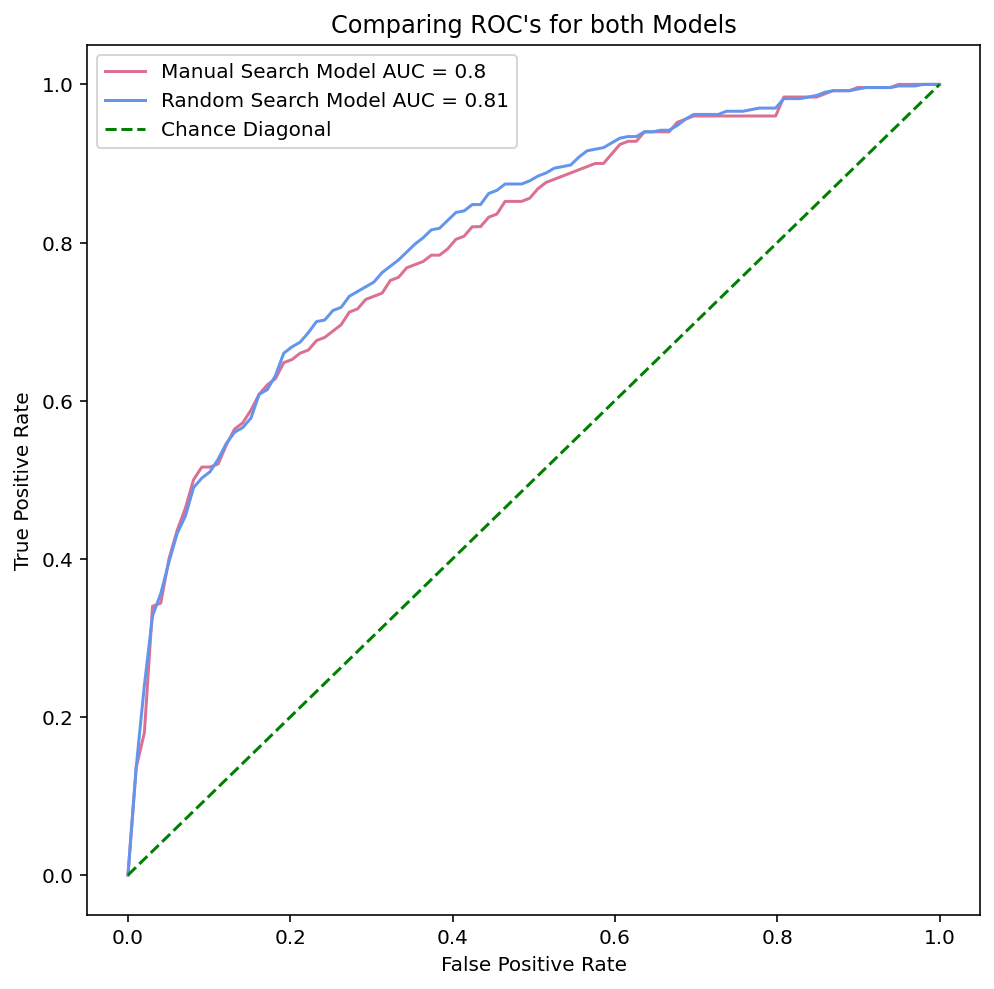

In [27]:
TPrates = []
auc_scores =[]
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(8,8))

C_Pallete = ['palevioletred', 'cornflowerblue']

i_0 = 0
for model, c, label in zip([optimized_manual_model, optimized_search_model], 
C_Pallete , ["Manual Search Model", "Random Search Model"]):
        prob_score = model.predict_proba(X_test)

        #Computing roc
        FP, TP, thresh = roc_curve(y_test, prob_score[:, 1])

        TPrates.append(np.interp(mean_fpr, FP, TP))
        TPrates[-1][0] = 0.0

        # Compute AUC given above TP and FP rate
        area = auc(FP, TP)
        auc_scores.append(area)
        i_0 += 1

        #Calculate mean TPR score
        mean_tpr = np.mean(TPrates, axis = 0)
        mean_tpr[-1] = 1.0

        #Find mean auc
        mean_auc = auc(mean_fpr, mean_tpr)

        print("The mean AUC score for 10-Fold CV " + label + ' is {}'.format(round(mean_auc, 3)))
        lab2 = label + " AUC = {}".format(round(mean_auc, 3))
        plt.plot(mean_fpr, mean_tpr, color = c, label = lab2)

# Plot the chance diagonal    
plt.plot([0,1], [0,1], linestyle = '--', color = 'green', label = 'Chance Diagonal')

plt.legend()
plt.title("Comparing ROC's for both Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

**Plot the final decision boundary for the greedy and random search-based classifiers along with the test dataset to demonstrate the shape of the final boundary**


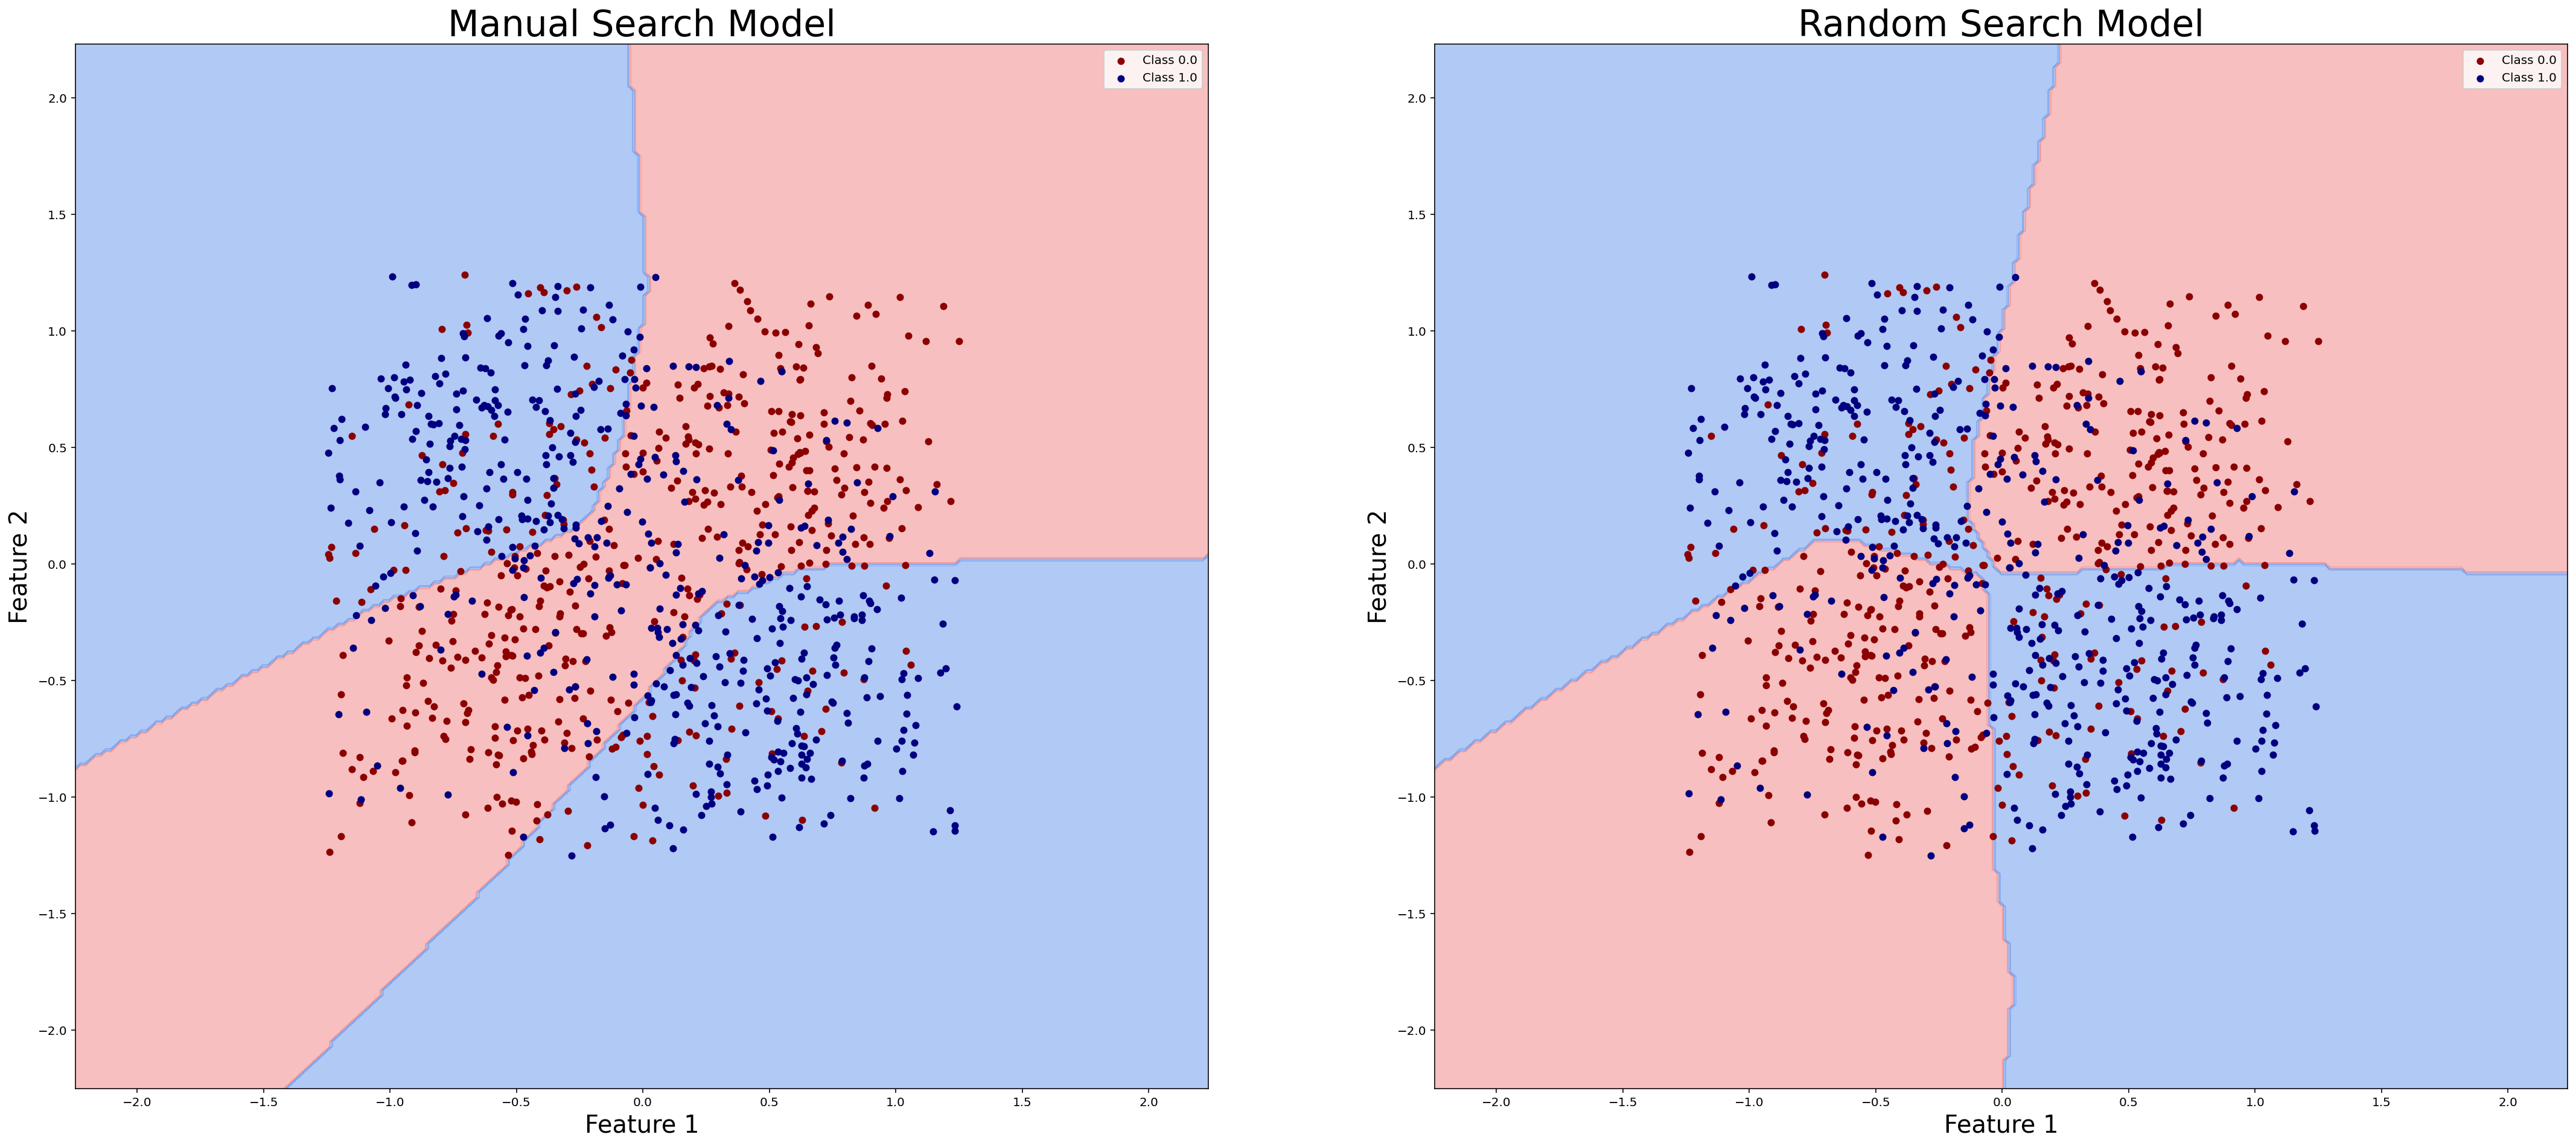

In [32]:
plt.figure(figsize =(37, 35))

models = [optimized_manual_model, optimized_search_model]
titles = ['Manual Search Model', 'Random Search Model']
cmap_light = ListedColormap(["lightcoral", "cornflowerblue"])
cmap_bold = {0: 'darkred', 1: 'navy'}

for m, x, tag in zip(models, [1, 2], titles):

    plt.subplot(2, 2, x)

    # Creating the grid
    x_min, x_max = X_train_plus_val[:, 0].min() - 1, X_train_plus_val[:, 0].max() + 1
    y_min, y_max = X_train_plus_val[:, 1].min() - 1, X_train_plus_val[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

    Z = m.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap = cmap_light , alpha = 0.5)

    for label in np.unique(y_train_plus_val):
        ind = np.where(y_train_plus_val == label)
        plt.scatter(X_train_plus_val[ind, 0], X_train_plus_val[ind, 1], c = cmap_bold[label], s = 25, 
                                            label = 'Class {}'.format(label))
    
    plt.xlabel("Feature 1", fontsize = 20)
    plt.ylabel("Feature 2", fontsize = 20)
    plt.title(tag, fontsize = 30)
    plt.legend(fontsize = 10)



**How did the generalization performance compare between the hyperparameters selected through the manual (greedy) search and the random search?**

The generalization for the random search model is better when visualized as a decision boundary since it captures the patterns in the two features without overfitting to the data (as it performs well on the test data as well). This can be observed both on the roc_curves for both models and perhaps more clearly on the decision boundaries. 